# Classifying AI-Generated vs Human-Written Text

This notebook constructs and assesses a text classification model that distinguishes AI-generated and human-written text. It covers the preparation of data, model construction, model testing, final model fitting and test submission creation.


In [1]:
import os, json, math, gc, random, time
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_recall_fscore_support

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import joblib
from tqdm.auto import tqdm
np.set_printoptions(suppress=True)



In [2]:
# ==== CONFIG ====
DATA_DIR = Path("./data")
TRAIN_AI_PATH = DATA_DIR / "train/train_ai.npy"
TRAIN_HUMAN_PATH = DATA_DIR / "train/train_human.npy"
VAL_JSONL = DATA_DIR / "train/validation.jsonl"       # optional sanity set
TEST_JSONL = DATA_DIR / "test/test_features.jsonl"   # required for submission

MODELS_DIR = Path("./models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

N_FOLDS = 5
SEED = 42
random.seed(SEED); np.random.seed(SEED)

SUBMISSION_PATH = Path("./submission.csv")
ART_SCALER = MODELS_DIR / "scaler.pkl"
ART_MODEL = MODELS_DIR / "logreg_calibrated.pkl"
ART_CONFIG = MODELS_DIR / "config.json"
ART_THRESHOLD = MODELS_DIR / "final_threshold.txt"


## Data Loading Utilities

This section defines helper functions for reading and preparing the training and validation data.  
- `load_train`: Loading the samples for the AI and humans stored in the `.npy` files. Outputs the feature block along with the related labels (1 for the AI, 0 for the human).
- `read_jsonl`: Reads a `.jsonl` file line by line and parses each line into a Python dictionary.  
- `load_jsonl_features`: Uses `read_jsonl` to get the document IDs and their embedding features. Documents are returned in a dictionary with the keys:
  - `id`: unique identifier for the document  
  - `features`: array of embeddings with shape `(<=100, 768)` 
  
## Masking and Mean Pooling

- `sentence_mask`: Checks if the rows in the embedding matrix are not zero.
  Produces a boolean mask for sentence vector validity. 

- `mean_pool`: Converts a variable-length sequence of embeddings into a single fixed-size vector by averaging only the non-zero rows.  
  Works robustly for different input shapes, including `(100, 768)` and multi-segment arrays.  
  Ensures that the output is always a 768-dimensional vector, even if no valid rows exist (in that case, returns zeros).  
  
  

## Conversion to Paragraph-Level Matrices

These functions turn document-level embedding blocks into a clean representation suitable for model training:  

- `to_paragraph_matrix_from_npy_block`:  
  Takes a NumPy block of shape `(n, 100, 768)` where `n` is the number of documents.  
  Applies `mean_pool` to each document, producing a matrix of shape `(n, 768)` where each row is a pooled document vector.  

- `to_paragraph_matrix_from_jsonl_items`:  
  Works with `.jsonl` data already loaded into Python dictionaries.  
  For each item, applies `mean_pool` to its feature array and collects the result in a DataFrame with columns:
  - `id`: document identifier  
  - `vector`: the pooled 768-dimensional representation  



In [3]:
def load_train(train_ai_path, train_human_path):
    X_ai = np.load(train_ai_path)      # (n_ai, 100, 768)
    X_h  = np.load(train_human_path)   # (n_h, 100, 768)
    y = np.array([1]*len(X_ai) + [0]*len(X_h), dtype=np.int64)
    X = np.concatenate([X_ai, X_h], axis=0)     # (n, 100, 768)
    return X, y

def read_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            yield json.loads(line)

def load_jsonl_features(path):
    """Returns: list of dicts with keys: id, features(np.array of shape (<=100,768))"""
    items = []
    for obj in read_jsonl(path):
        # Expect at least {"id": ..., "features": [[...],[...],...]}
        pid = obj.get("id")
        feats = np.asarray(obj.get("features"), dtype=np.float32)
        # Ensure 2D (n_sent, 768)
        if feats.ndim == 1:
            feats = feats.reshape(1, -1)
        items.append({"id": pid, "features": feats})
    return items

def sentence_mask(x, eps=1e-8):
    """
    Works for (..., 768) – returns mask of shape (...,)
    True where the 768-d vector is non-zero.
    """
    x = np.asarray(x, dtype=np.float32)
    norms = np.linalg.norm(x, axis=-1)
    return (norms > eps)

def mean_pool(x):
    """
    Robust mean pooling:
    - Accepts (100,768)
    - Accepts (segments, 100, 768)
    - Flattens all leading dims into a single sequence of 768-d vectors,
      masks near-zero rows, and averages.
    Returns: (768,)
    """
    x = np.asarray(x, dtype=np.float32)
    if x.ndim < 2:
        # Unexpected shape – return zeros
        return np.zeros((768,), dtype=np.float32)

    # Ensure last dim is feature dim
    feat_dim = x.shape[-1]
    if feat_dim != 768:
        raise ValueError(f"Expected last dim = 768, got {feat_dim} with shape {x.shape}")

    # Flatten all but last dim to get (N, 768), where N = product of leading dims
    x_flat = x.reshape(-1, feat_dim)  # (N, 768)

    m = sentence_mask(x_flat).astype(np.float32)  # (N,)
    count = m.sum()
    if count < 1:
        return np.zeros((feat_dim,), dtype=np.float32)

    return (x_flat * m[:, None]).sum(axis=0) / count

def to_paragraph_matrix_from_npy_block(X):
    """X: (n, 100, 768) -> (n, 768) pooled"""
    pooled = np.zeros((X.shape[0], X.shape[2]), dtype=np.float32)
    for i in range(X.shape[0]):
        pooled[i] = mean_pool(X[i])
    return pooled

def to_paragraph_matrix_from_jsonl_items(items):
    """items: list of dict with features (shape (100,768) or (S,100,768)) -> DataFrame(id, vector)"""
    rows = []
    for obj in items:
        pid = obj["id"]
        vec = mean_pool(obj["features"])
        rows.append({"id": pid, "vector": vec})
    return pd.DataFrame(rows)


## Data

We load embeddings for both AI-generated and human-written documents.  
Each document contains up to **100 sentence embeddings** of dimension **768**.  
Labels are assigned as:

- $y = 1$ → AI-generated  
- $y = 0$ → Human  

We check for missing or invalid values and, where available, also load optional validation/test features in the same format.

## Exploratory Analysis

- **Class balance**: Compare counts of AI vs. human samples.  
- **Vector norms**: Histogram of $\|v\|_2$ for each class.  
- **Intra-document variability**: Variance across embeddings within a document.  

We also run PCA for visualization:

- First two components give a coarse separation view.  
- Explained variance ratio (EVR) shows how concentrated the variance is:




Train raw shape: (16322, 100, 768) Labels: (16322,) Pos rate: 0.5


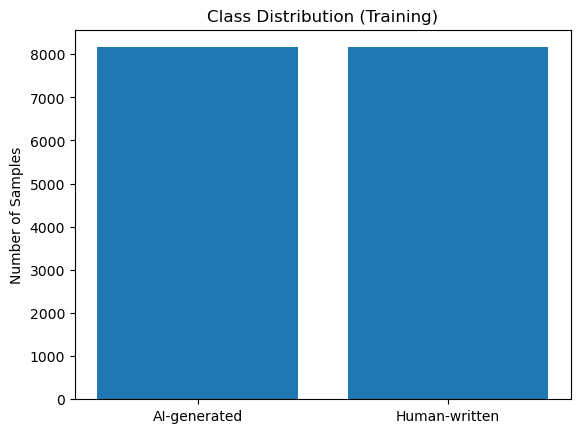

Raw — AI:   NaNs= 0  Infs= 0
Raw — Human: NaNs= 0  Infs= 0


In [17]:
X_raw, y = load_train(TRAIN_AI_PATH, TRAIN_HUMAN_PATH)
print("Train raw shape:", X_raw.shape, "Labels:", y.shape, "Pos rate:", y.mean())


n_ai = int((y == 1).sum())
n_h  = int((y == 0).sum())

plt.figure()
plt.bar(["AI-generated", "Human-written"], [n_ai, n_h])
plt.title("Class Distribution (Training)")
plt.ylabel("Number of Samples")
plt.show()

# NaN/Inf checks on raw arrays by class
X_ai_raw = X_raw[y == 1]
X_h_raw  = X_raw[y == 0]
print("Raw — AI:   NaNs=", np.isnan(X_ai_raw).sum(), " Infs=", np.isinf(X_ai_raw).sum())
print("Raw — Human: NaNs=", np.isnan(X_h_raw).sum(), " Infs=", np.isinf(X_h_raw).sum())


Pooled train shape: (16322, 768)


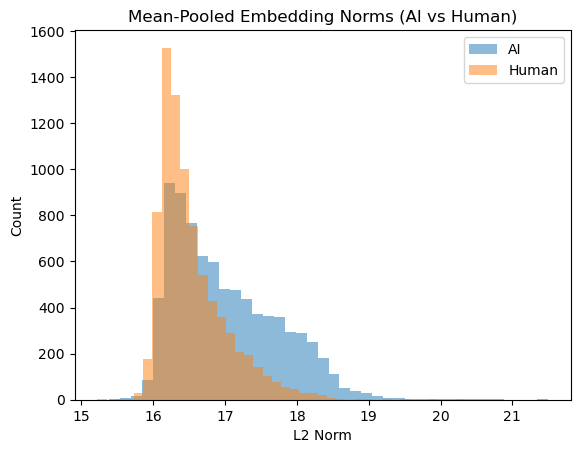

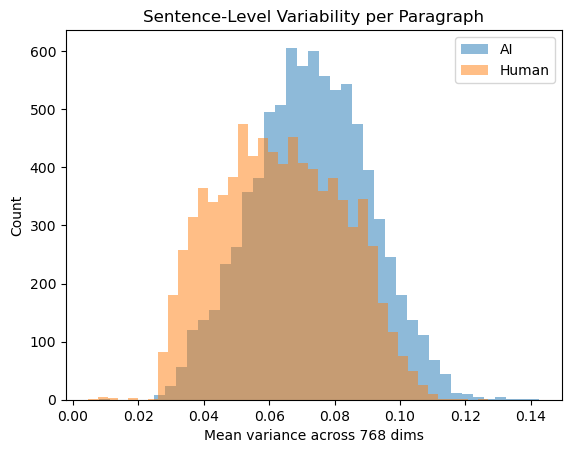

In [60]:
X = to_paragraph_matrix_from_npy_block(X_raw)
print("Pooled train shape:", X.shape)


# --- Feature-level visuals (post mean-pooling) ---
# 2A) Mean-pooled embedding norms by class
ai_norms = np.linalg.norm(X[y == 1], axis=1)
h_norms  = np.linalg.norm(X[y == 0], axis=1)

plt.figure()
plt.hist(ai_norms, bins=40, alpha=0.5, label="AI")
plt.hist(h_norms,  bins=40, alpha=0.5, label="Human")
plt.title("Mean-Pooled Embedding Norms (AI vs Human)")
plt.xlabel("L2 Norm"); plt.ylabel("Count"); plt.legend()
plt.show()

# 2B) Sentence-level variability per paragraph (from raw 100×768)
#     Measures diversity of sentence embeddings inside each paragraph
ai_var = X_ai_raw.var(axis=1).mean(axis=1)   # shape (n_ai,)
h_var  = X_h_raw.var(axis=1).mean(axis=1)    # shape (n_h,)

plt.figure()
plt.hist(ai_var, bins=40, alpha=0.5, label="AI")
plt.hist(h_var, bins=40, alpha=0.5, label="Human")
plt.title("Sentence-Level Variability per Paragraph")
plt.xlabel("Mean variance across 768 dims"); plt.ylabel("Count"); plt.legend()
plt.show()

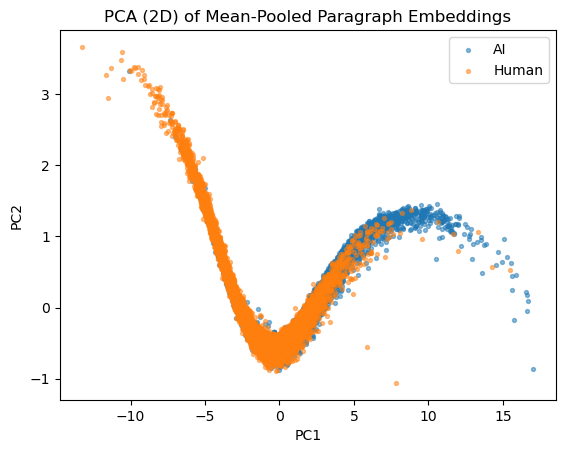

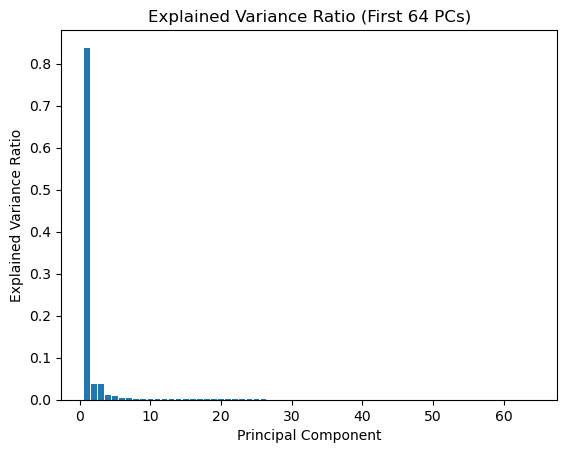

In [21]:
# --- PCA-based structure check (before training) ---
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# 3A) 2D PCA scatter to inspect separability
pca2 = PCA(n_components=2, random_state=SEED).fit(X)
Z = pca2.transform(X)

plt.figure()
plt.scatter(Z[y==1,0], Z[y==1,1], s=8, alpha=0.5, label="AI")
plt.scatter(Z[y==0,0], Z[y==0,1], s=8, alpha=0.5, label="Human")
plt.title("PCA (2D) of Mean-Pooled Paragraph Embeddings")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.show()

# 3B) Explained variance (first up to 64 PCs)
k = min(64, X.shape[1])
pcaK = PCA(n_components=k, random_state=SEED).fit(X)
evr = pcaK.explained_variance_ratio_

plt.figure()
plt.bar(np.arange(1, len(evr)+1), evr)
plt.title("Explained Variance Ratio (First {} PCs)".format(k))
plt.xlabel("Principal Component"); plt.ylabel("Explained Variance Ratio")
plt.show()



## Cross-Validation Training and Out-of-Fold Evaluation

This section defines the function `fit_oof_cv`, which handles model training and evaluation in a structured way:

- **Purpose**:  
  To train the model using stratified cross-validation, collect out-of-fold (OOF) predictions, and summarize performance across folds.

- **Key Features**:
  - Splits the dataset into a given number of folds (default = 5).
  - For each fold, the model is trained on a training split and evaluated on a validation split.
  - Tracks predictions for the validation set across all folds, giving unbiased out-of-fold probabilities for the whole dataset.
  - Tests multiple regularization strengths (`C` values) and keeps the best-performing model for each fold.
  - Determines a threshold per fold that maximizes the F1 score.
  - Collects performance metrics such as AUC, F1, accuracy, precision, recall, and the chosen threshold.

- **Outputs**:
  - `oof_pred`: an array of out-of-fold probabilities (same length as the dataset).
  - `summary`: a dictionary containing:
    - Overall metrics calculated from the OOF predictions (AUC, F1, accuracy, precision, recall).
    - The final decision threshold (median of the fold thresholds).
    - A list of per-fold metrics for detailed inspection.



In [5]:
from sklearn.base import clone

def fit_oof_cv(X, y, n_folds=5, seed=42):
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    oof_pred = np.zeros(len(y), dtype=np.float32)
    oof_thr_list, fold_metrics = [], []
    C_grid = [0.5, 1.0, 2.0]

    for fold, (trn_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_tr, X_va = X[trn_idx], X[val_idx]
        y_tr, y_va = y[trn_idx], y[val_idx]

        best_auc, best_model = -1, None
        for C in C_grid:
            base = Pipeline([
                ("scaler", StandardScaler(with_mean=True, with_std=True)),
                ("clf", LogisticRegression(
                    penalty="l2", solver="saga", max_iter=4000, C=C, n_jobs=-1, random_state=seed))
            ])
            cal = CalibratedClassifierCV(estimator=base, method="isotonic", cv=3)
            cal.fit(X_tr, y_tr)
            p_va = cal.predict_proba(X_va)[:, 1]
            auc = roc_auc_score(y_va, p_va)
            if auc > best_auc:
                best_auc, best_model, best_p_va = auc, cal, p_va

        p_va = best_p_va
        oof_pred[val_idx] = p_va

        # F1-optimal threshold
        best_thr, best_f1 = 0.5, -1
        for t in np.linspace(0.01, 0.99, 199):
            f1 = f1_score(y_va, (p_va >= t).astype(int))
            if f1 > best_f1:
                best_f1, best_thr = f1, t

        pred_lbl = (p_va >= best_thr).astype(int)
        auc = roc_auc_score(y_va, p_va)
        acc = accuracy_score(y_va, pred_lbl)
        prec, rec, f1, _ = precision_recall_fscore_support(y_va, pred_lbl, average="binary", zero_division=0)
        fold_metrics.append({"fold": fold, "AUC": auc, "F1": f1, "Acc": acc, "Prec": prec, "Rec": rec, "thr": best_thr})
        oof_thr_list.append(best_thr)
        print(f"[Fold {fold}] AUC={auc:.4f} F1={f1:.4f} Acc={acc:.4f} Prec={prec:.4f} Rec={rec:.4f} Thr={best_thr:.3f}")

    oof_auc = roc_auc_score(y, oof_pred)
    final_thr = float(np.median(oof_thr_list))
    pred_lbl = (oof_pred >= final_thr).astype(int)
    oof_acc = accuracy_score(y, pred_lbl)
    oof_prec, oof_rec, oof_f1, _ = precision_recall_fscore_support(y, pred_lbl, average="binary", zero_division=0)
    summary = {"OOF_AUC": oof_auc, "OOF_F1": oof_f1, "OOF_Acc": oof_acc, "OOF_Prec": oof_prec, "OOF_Rec": oof_rec,
               "final_thr": final_thr, "folds": fold_metrics}
    return oof_pred, summary


oof_pred, summary = fit_oof_cv(X, y, n_folds=N_FOLDS, seed=SEED)
print("\n=== OOF Summary ===")
for k, v in summary.items():
    if k != "folds":
        print(f"{k}: {v}")
pd.DataFrame(summary["folds"])


[Fold 1] AUC=0.9686 F1=0.9085 Acc=0.9066 Prec=0.8906 Rec=0.9271 Thr=0.465
[Fold 2] AUC=0.9658 F1=0.9033 Acc=0.9029 Prec=0.8992 Rec=0.9075 Thr=0.485
[Fold 3] AUC=0.9649 F1=0.9045 Acc=0.9020 Prec=0.8814 Rec=0.9289 Thr=0.475
[Fold 4] AUC=0.9644 F1=0.9033 Acc=0.9017 Prec=0.8881 Rec=0.9191 Thr=0.416
[Fold 5] AUC=0.9679 F1=0.9057 Acc=0.9035 Prec=0.8853 Rec=0.9271 Thr=0.455

=== OOF Summary ===
OOF_AUC: 0.9660641019648668
OOF_F1: 0.9043258223882396
OOF_Acc: 0.9027080014704081
OOF_Prec: 0.8895341946189403
OOF_Rec: 0.9196176939100601
final_thr: 0.46535353535353535


,fold,AUC,F1,Acc,Prec,Rec,thr
0,1,0.968649,0.908491,0.906585,0.890588,0.927128,0.465354
1,2,0.965775,0.903324,0.902910,0.899211,0.907475,0.485152
2,3,0.964851,0.904535,0.901961,0.881395,0.928922,0.475253
3,4,0.964383,0.903342,0.901654,0.888099,0.919118,0.415859
4,5,0.967931,0.905717,0.903493,0.885313,0.927083,0.455455


## Validation Set Evaluation

This function `evaluate_on_validation` is used to check how well the final trained model performs on a separate validation file.

- **Purpose**:  
  To apply the trained model on a labeled validation dataset and compute performance metrics using the previously chosen decision threshold.

- **Process**:
  - Checks whether a validation file exists. If not, it skips evaluation.  
  - Loads document embeddings and converts them into pooled vectors (one per document).  
  - Reads the true labels from the validation file (expects a `label` field for each entry).  
  - Uses the trained model to predict probabilities for each validation sample.  
  - Applies the chosen decision threshold to turn probabilities into binary predictions.  
  - Computes evaluation metrics: AUC, F1 score, accuracy, precision, and recall.  

- **Outputs**:
  - Prints a concise line showing validation performance across all metrics.  
  - Returns a dictionary containing the metrics for further use.  


In [8]:
def evaluate_on_validation(val_jsonl_path, model, threshold):
    if not Path(val_jsonl_path).exists():
        print("No validation file found. Skipping.")
        return None
    items = load_jsonl_features(val_jsonl_path)
    dfv = to_paragraph_matrix_from_jsonl_items(items)
    # Expect labels exist in validation.jsonl; if not, skip
    # Common schema: {"id":..., "features":[...], "label": 0/1}
    labels = []
    for obj in read_jsonl(val_jsonl_path):
        labels.append(int(obj.get("label", 0)))
    yv = np.array(labels, dtype=np.int64)

    Xv = np.stack(dfv["vector"].values)  # (n, 768)
    pv = model.predict_proba(Xv)[:, 1]
    auc = roc_auc_score(yv, pv)
    yhat = (pv >= threshold).astype(int)
    acc = accuracy_score(yv, yhat)
    prec, rec, f1, _ = precision_recall_fscore_support(yv, yhat, average="binary", zero_division=0)
    print(f"[Validation] AUC={auc:.4f} F1={f1:.4f} Acc={acc:.4f} Prec={prec:.4f} Rec={rec:.4f}")
    return {"AUC":auc, "F1":f1, "Acc":acc, "Prec":prec, "Rec":rec}

_ = evaluate_on_validation(VAL_JSONL, final_model, summary["final_thr"])

[Validation] AUC=0.9900 F1=0.6667 Acc=0.7500 Prec=1.0000 Rec=0.5000


## Final Model Training, Threshold Selection, and Artefact Saving

This section wraps up the entire training process by creating the final model, selecting the threshold to use in practice, and saving everything needed for reproducibility.

- **Final Training**  
  The model is re-trained on the **full training dataset**, using the best configuration identified during cross-validation.

- **Threshold Choice**  
  Two thresholds are considered:
  - The median threshold derived from cross-validation results.  
  - A slightly adjusted version (lowered by a small amount) to balance precision and recall differently.  
  Both are evaluated on the validation set, and one is selected as the final operating threshold.

- **Artefact Saving**  
  To make the work reproducible and portable:
  - The trained model is saved with `joblib`.  
  - A configuration file (`.json`) is written, recording key parameters such as the random seed, number of folds, model type, and thresholds.  
  - The chosen threshold is also saved separately for quick loading in inference scripts.  
  


In [9]:
# === Final fit (LogReg + isotonic calibration), threshold selection, and artefact saving ===

# 1) Fit calibrated final model on ALL training data
best_C = 1.0 
final_base = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(
        penalty="l2", solver="saga", max_iter=4000, C=best_C, n_jobs=-1, random_state=SEED))
])
final_model = CalibratedClassifierCV(estimator=final_base, method="isotonic", cv=5)
final_model.fit(X, y)

# 2) Choose threshold
#    Start from OOF-derived median threshold, then (optionally) nudge down a bit to trade precision for recall.
thr_oof = float(summary["final_thr"])
thr_val = max(0.0, thr_oof - 0.05)  # small nudge; adjust if needed

print("== OOF-based threshold ==", thr_oof)
_ = evaluate_on_validation(VAL_JSONL, final_model, thr_oof)

print("== Val-nudged threshold ==", thr_val)
_ = evaluate_on_validation(VAL_JSONL, final_model, thr_val)

# Pick which threshold you want to use going forward:
chosen_threshold = thr_val   # or use thr_oof if you prefer higher precision

# 3) Save artefacts
joblib.dump(final_model, ART_MODEL)

config = {
    "seed": SEED,
    "n_folds": N_FOLDS,
    "clf": "LogReg(saga)+Calibrated(isotonic)",
    "C": best_C,
    "vector": "mean_pool_768",
    "final_threshold_oof": thr_oof,
    "final_threshold_chosen": chosen_threshold
}
json.dump(config, open(ART_CONFIG, "w"))

with open(ART_THRESHOLD, "w") as f:
    f.write(str(chosen_threshold))

print("Saved:", ART_MODEL, ART_CONFIG, ART_THRESHOLD)


== OOF-based threshold == 0.46535353535353535
[Validation] AUC=0.9900 F1=0.6667 Acc=0.7500 Prec=1.0000 Rec=0.5000
== Val-nudged threshold == 0.41535353535353536
[Validation] AUC=0.9900 F1=0.6667 Acc=0.7500 Prec=1.0000 Rec=0.5000
Saved: models/logreg_calibrated.pkl models/config.json models/final_threshold.txt


## Test Submission and Model Diagnostics

This section finalizes the workflow by preparing a Kaggle-compliant submission file and visualizing key diagnostic plots for the model.

- **Test Submission**  
  The helper function `predict_test_and_write_submission_prob` runs the final model on the test set, collects predicted probabilities, and writes them to a CSV file.  
  - Output format: two columns `id` and `y_prob`.  
  - No thresholding is applied here — raw probabilities are saved since the competition leaderboard expects them.  

- **Performance Diagnostics**  
  Several plots are generated to understand the model’s behavior on out-of-fold predictions from cross-validation:  
  - **ROC Curve** with overall area-under-curve (AUC).  
  - **Precision–Recall Curve** with average precision.  
  - **Threshold Sweep** showing how the F1 score changes at different probability cutoffs, with the chosen threshold marked.  
  - **Reliability Diagram** showing how well predicted probabilities match observed outcomes, alongside the Brier score.  
  - **Predicted Probability Distributions** comparing AI versus human texts, to visualize separation.  
  - **Per-Fold Bar Chart** comparing AUC and F1 scores across folds, for stability checks.
 


In [10]:
# === Kaggle-compliant: id,y_prob (no thresholding) ===
def predict_test_and_write_submission_prob(test_jsonl_path, model, out_csv_path):
    items = load_jsonl_features(test_jsonl_path)
    dft = to_paragraph_matrix_from_jsonl_items(items)
    Xt = np.stack(dft["vector"].values)
    y_prob = model.predict_proba(Xt)[:, 1]          # <-- probability of class 1
    sub = pd.DataFrame({"id": dft["id"], "y_prob": y_prob})
    sub.to_csv(out_csv_path, index=False)
    print("Wrote submission to:", out_csv_path)
    return sub

# write the prob file
SUBMISSION_BASE_PROB = Path("./submission_base_prob.csv")
_ = predict_test_and_write_submission_prob(TEST_JSONL, final_model, SUBMISSION_BASE_PROB)


Wrote submission to: submission_base_prob.csv


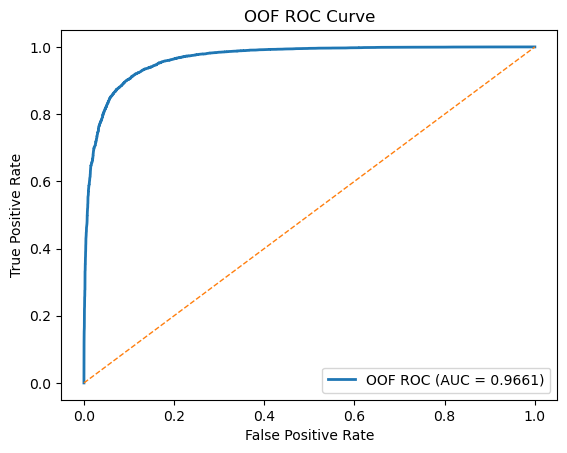

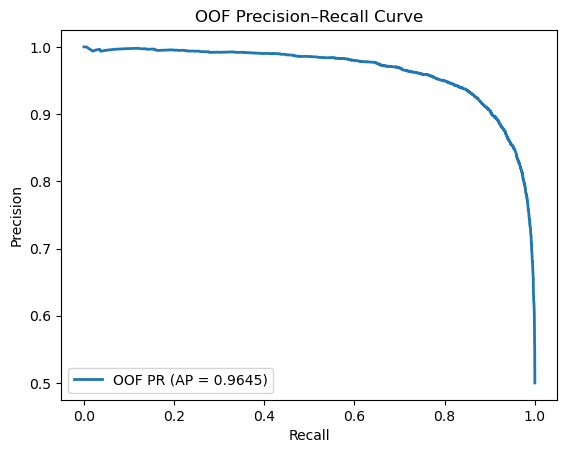

In [22]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# ROC
fpr, tpr, _ = roc_curve(y, oof_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"OOF ROC (AUC = {roc_auc:.4f})")
plt.plot([0,1], [0,1], lw=1, linestyle="--")
plt.title("OOF ROC Curve")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.show()

# Precision–Recall
prec, rec, _ = precision_recall_curve(y, oof_pred)
ap = average_precision_score(y, oof_pred)

plt.figure()
plt.plot(rec, prec, lw=2, label=f"OOF PR (AP = {ap:.4f})")
plt.title("OOF Precision–Recall Curve")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(); plt.show()


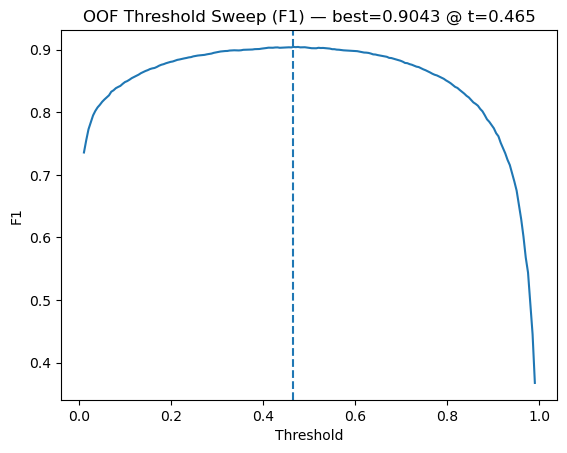

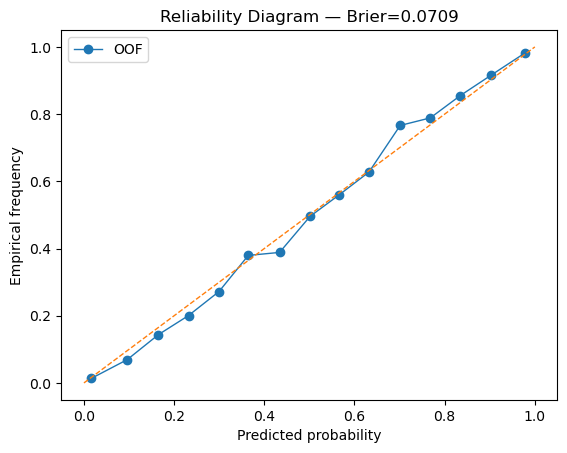

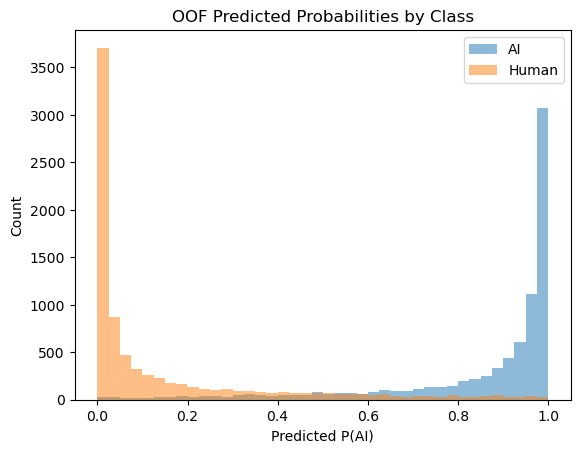

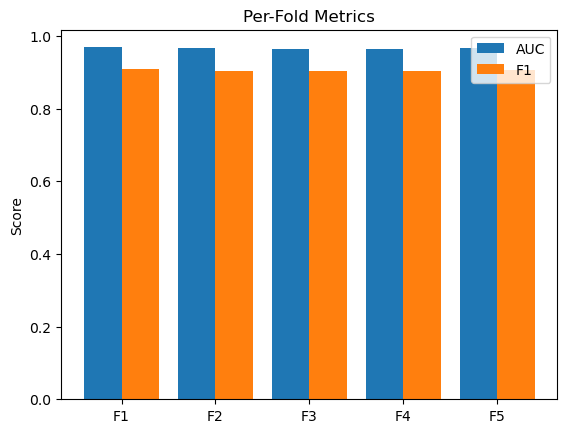

In [24]:
from sklearn.metrics import f1_score

ts = np.linspace(0.01, 0.99, 199)
f1s = [f1_score(y, (oof_pred >= t).astype(int)) for t in ts]
best_t = float(summary["final_thr"])
best_f1 = f1_score(y, (oof_pred >= best_t).astype(int))

plt.figure()
plt.plot(ts, f1s)
plt.axvline(best_t, linestyle="--")
plt.title(f"OOF Threshold Sweep (F1) — best={best_f1:.4f} @ t={best_t:.3f}")
plt.xlabel("Threshold"); plt.ylabel("F1")
plt.show()

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

prob_true, prob_pred = calibration_curve(y, oof_pred, n_bins=15, strategy="uniform")
brier = brier_score_loss(y, oof_pred)

plt.figure()
plt.plot(prob_pred, prob_true, marker="o", lw=1, label="OOF")
plt.plot([0,1], [0,1], linestyle="--", lw=1)
plt.title(f"Reliability Diagram — Brier={brier:.4f}")
plt.xlabel("Predicted probability"); plt.ylabel("Empirical frequency")
plt.legend(); plt.show()


plt.figure()
plt.hist(oof_pred[y==1], bins=40, alpha=0.5, label="AI")
plt.hist(oof_pred[y==0], bins=40, alpha=0.5, label="Human")
plt.title("OOF Predicted Probabilities by Class")
plt.xlabel("Predicted P(AI)"); plt.ylabel("Count"); plt.legend()
plt.show()


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fold_df = pd.DataFrame(summary["folds"])
xs = np.arange(len(fold_df))
plt.figure()
plt.bar(xs - 0.2, fold_df["AUC"], width=0.4, label="AUC")
plt.bar(xs + 0.2, fold_df["F1"],  width=0.4, label="F1")
plt.xticks(xs, [f"F{int(f)}" for f in fold_df["fold"]])
plt.title("Per-Fold Metrics")
plt.ylabel("Score"); plt.legend(); plt.show()

